# Building a Recommendation System- Exploratory Data Analysis (EDA)

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from yellowbrick.target import FeatureCorrelation
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
import plotly.express as px

In [2]:
df_cont= pd.read_csv('/Users/josephlim/Desktop/Data Science/Capstone Projects/Music Recommendation System- Capstone 3/Data/Raw data/songs_normalize.csv')
df_collab= pd.read_csv('/Users/josephlim/Desktop/Data Science/Capstone Projects/Music Recommendation System- Capstone 3/Data/df_collab_cleaned.csv')

In [3]:
df_cont.shape

(2000, 18)

In [4]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


In [5]:
df_cont.head()

artist                    song  duration_ms  explicit  year  \
0  Britney Spears  Oops!...I Did It Again       211160     False  2000   
1       blink-182    All The Small Things       167066     False  1999   
2      Faith Hill                 Breathe       250546     False  1999   
3        Bon Jovi            It's My Life       224493     False  2000   
4          *NSYNC             Bye Bye Bye       200560     False  2000   

   popularity  danceability  energy  key  loudness  mode  speechiness  \
0          77         0.751   0.834    1    -5.444     0       0.0437   
1          79         0.434   0.897    0    -4.918     1       0.0488   
2          66         0.529   0.496    7    -9.007     1       0.0290   
3          78         0.551   0.913    0    -4.063     0       0.0466   
4          65         0.614   0.928    8    -4.806     0       0.0516   

   acousticness  instrumentalness  liveness  valence    tempo         genre  
0        0.3000          0.000018    0.3550    0.894   95.053           pop  
1        0.0103          0.000000    0.6120    0.684  148.726     rock, pop  
2        0.1730          0.000000    0.2510    0.278  136.859  pop, country  
3        0.0263          0.000013    0.3470    0.544  119.992   rock, metal  
4        0.0408          0.001040    0.0845    0.879  172.656           pop

In [6]:
df_cont= df_cont.rename(columns={'release_date':'year'})

## Feature Correlation

We will explore correlations between different combinations of features.

#### Correlation Between Different Features and Popularity

 Before we go into an in-depth analysis, let's explore correlations between features.

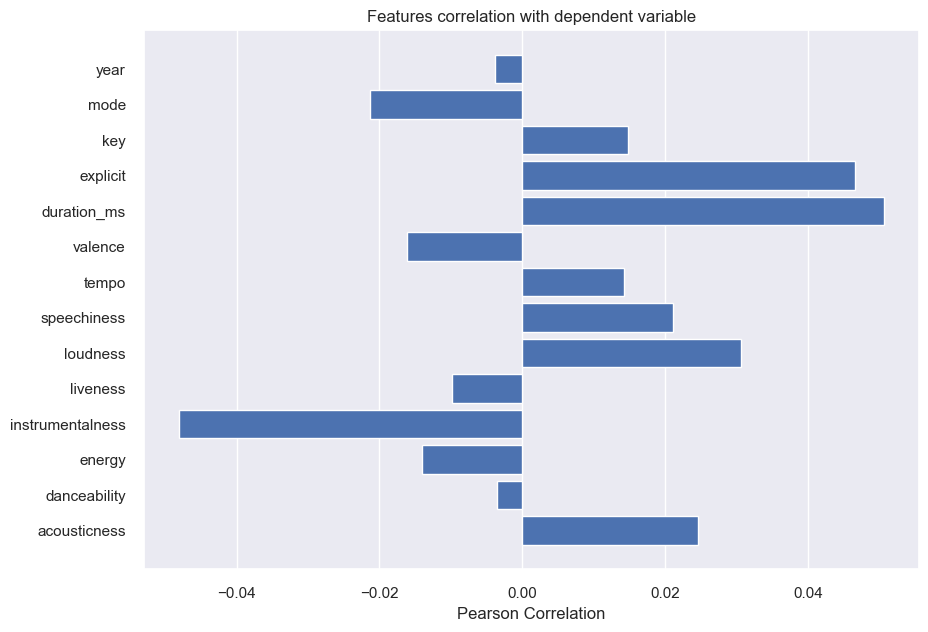

<AxesSubplot: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [7]:
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

sns.set(font_scale=1)
X= df_cont[feature_names]
y= df_cont['popularity']

features= np.array(X.columns)
visualizer= FeatureCorrelation(labels= features)

plt.rcParams['figure.figsize']=(10, 7)
visualizer.fit(X, y)
visualizer.show()

We don't see any feature that has noticeable correlation with popularity.

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


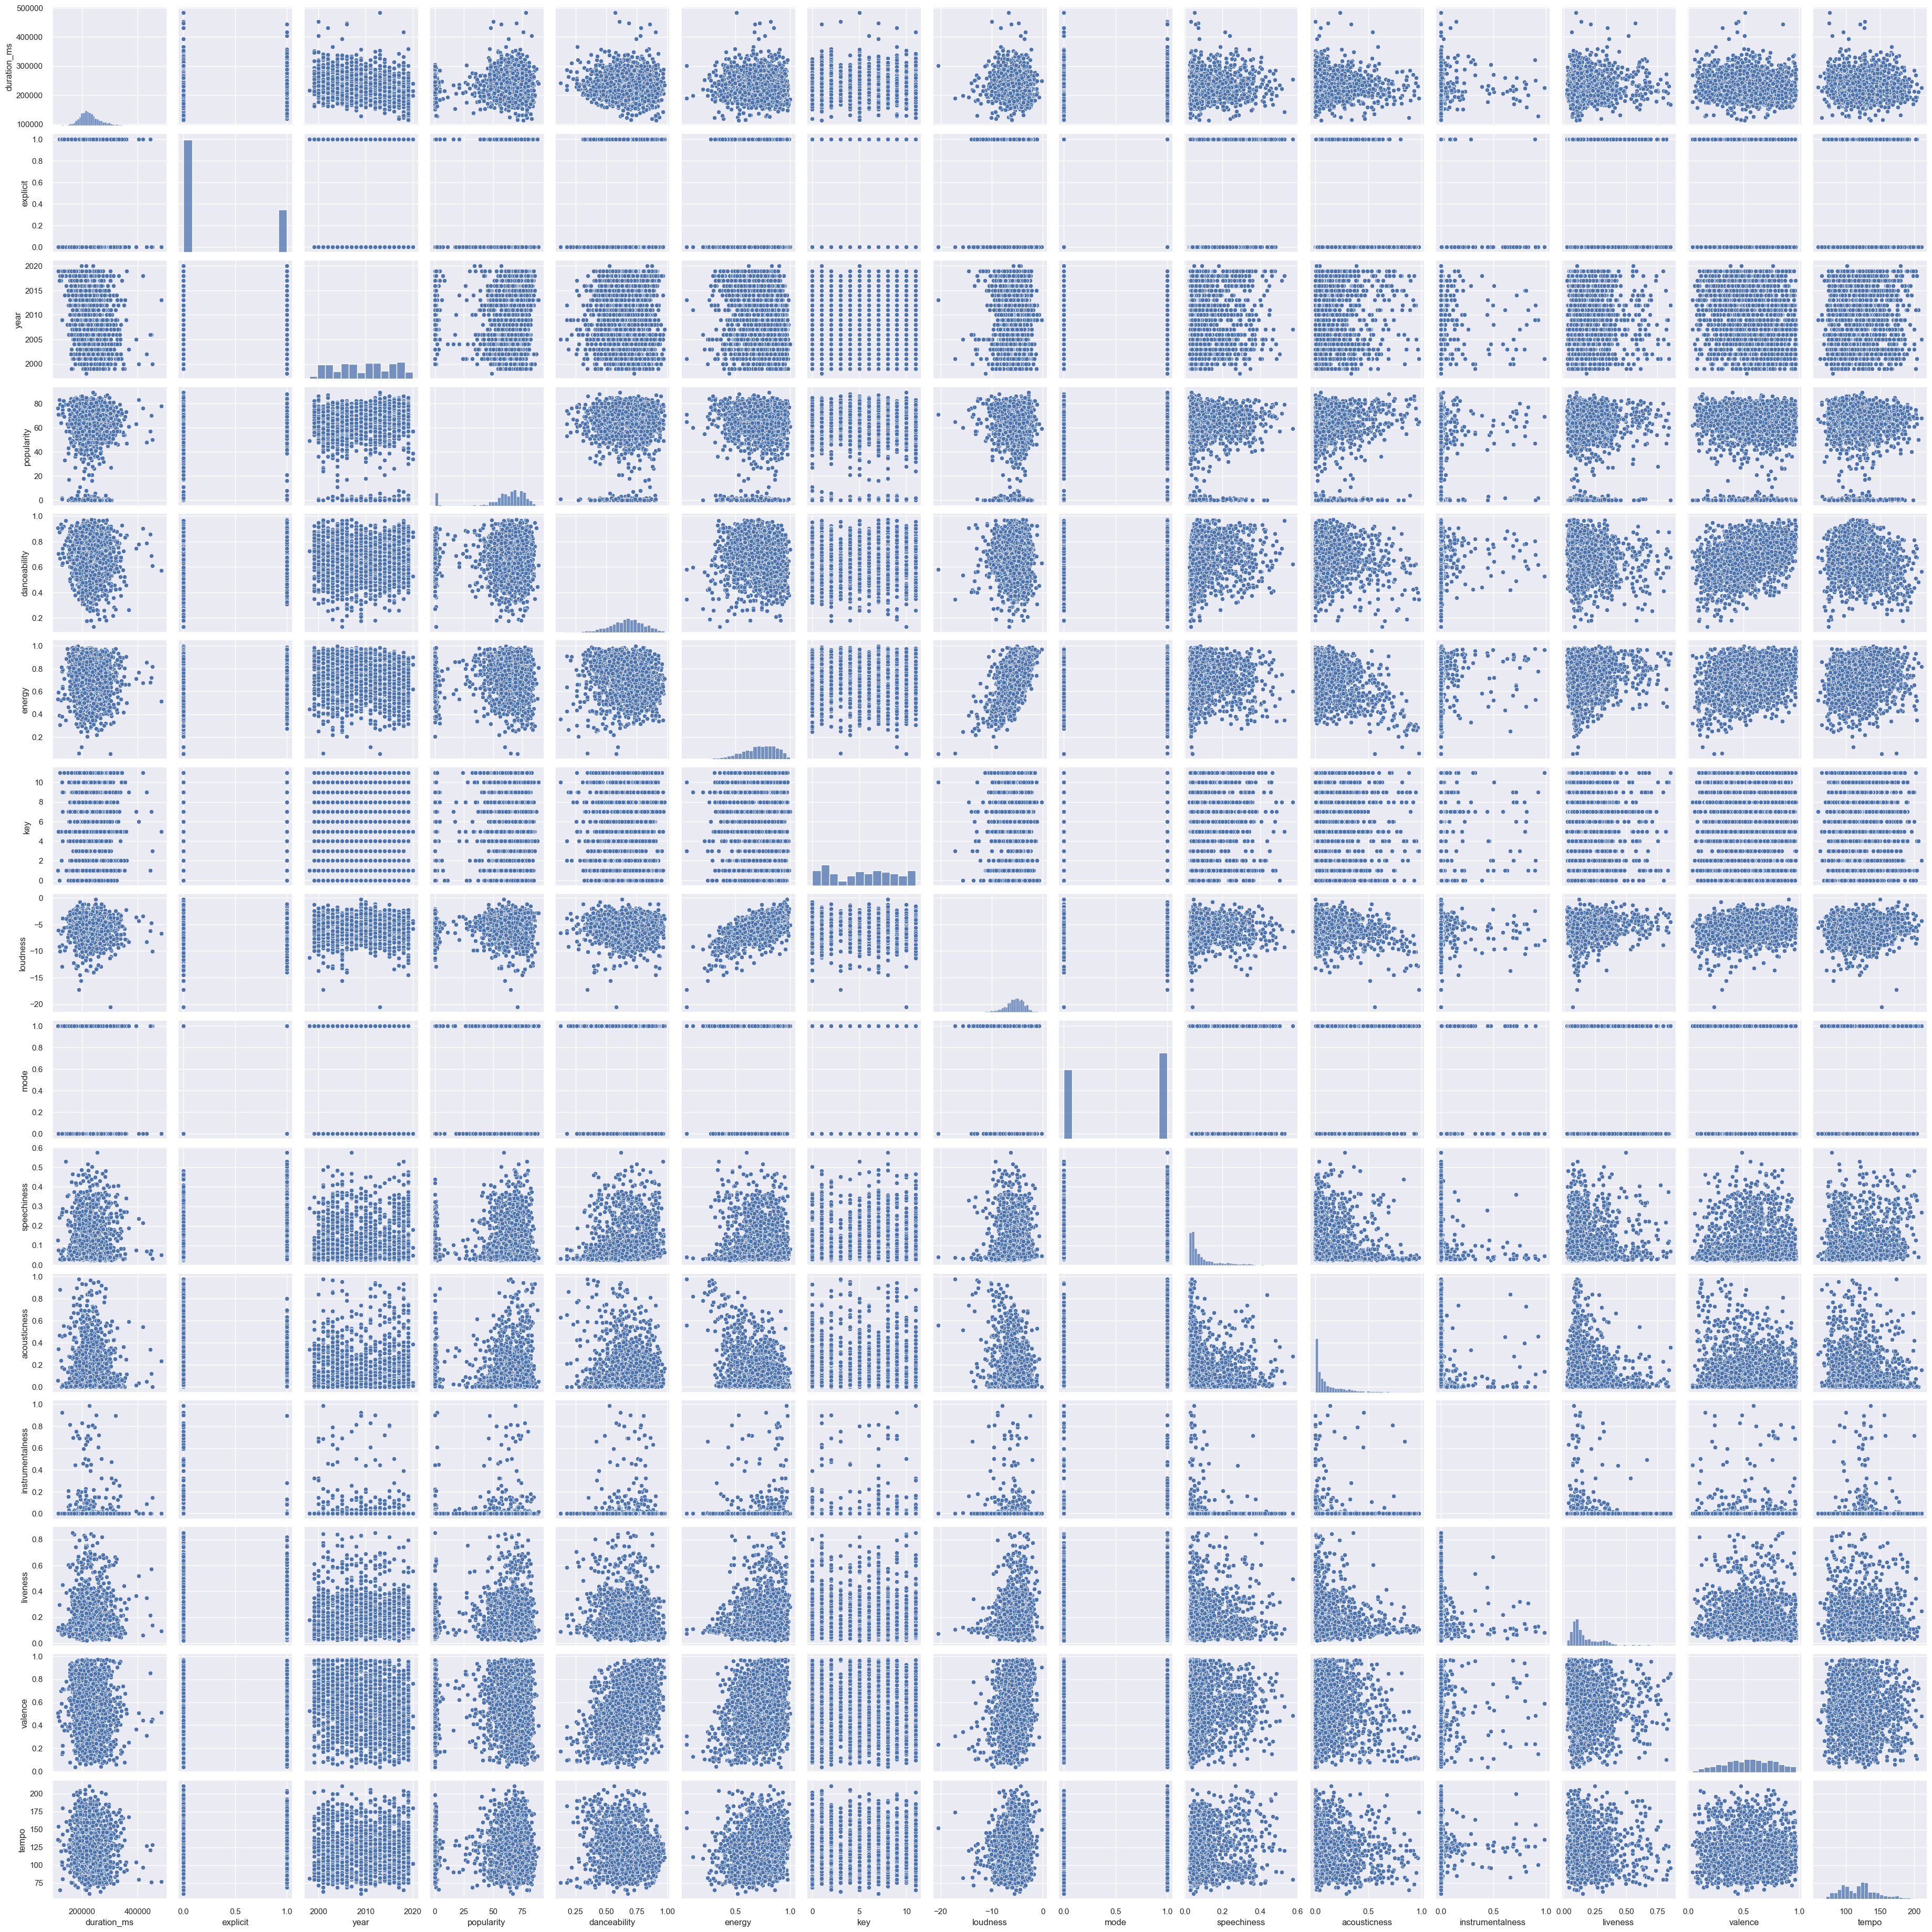

In [8]:
g= sns.pairplot(df_cont)
plt.show()

Seems like we have very little to no correlation between features, but it's a bit difficult to tell. Let's try to visualize this using heatmap.

/var/folders/z9/t15ddpld70nc5qf41442lpr80000gn/T/ipykernel_2060/4023651303.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_cont.corr(), linewidths=0.1, cmap='YlGnBu', annot=True)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0, 0.5, 'duration_ms'),
  Text(0, 1.5, 'explicit'),
  Text(0, 2.5, 'year'),
  Text(0, 3.5, 'popularity'),
  Text(0, 4.5, 'danceability'),
  Text(0, 5.5, 'energy'),
  Text(0, 6.5, 'key'),
  Text(0, 7.5, 'loudness'),
  Text(0, 8.5, 'mode'),
  Text(0, 9.5, 'speechiness'),
  Text(0, 10.5, 'acousticness'),
  Text(0, 11.5, 'instrumentalness'),
  Text(0, 12.5, 'liveness'),
  Text(0, 13.5, 'valence'),
  Text(0, 14.5, 'tempo')])

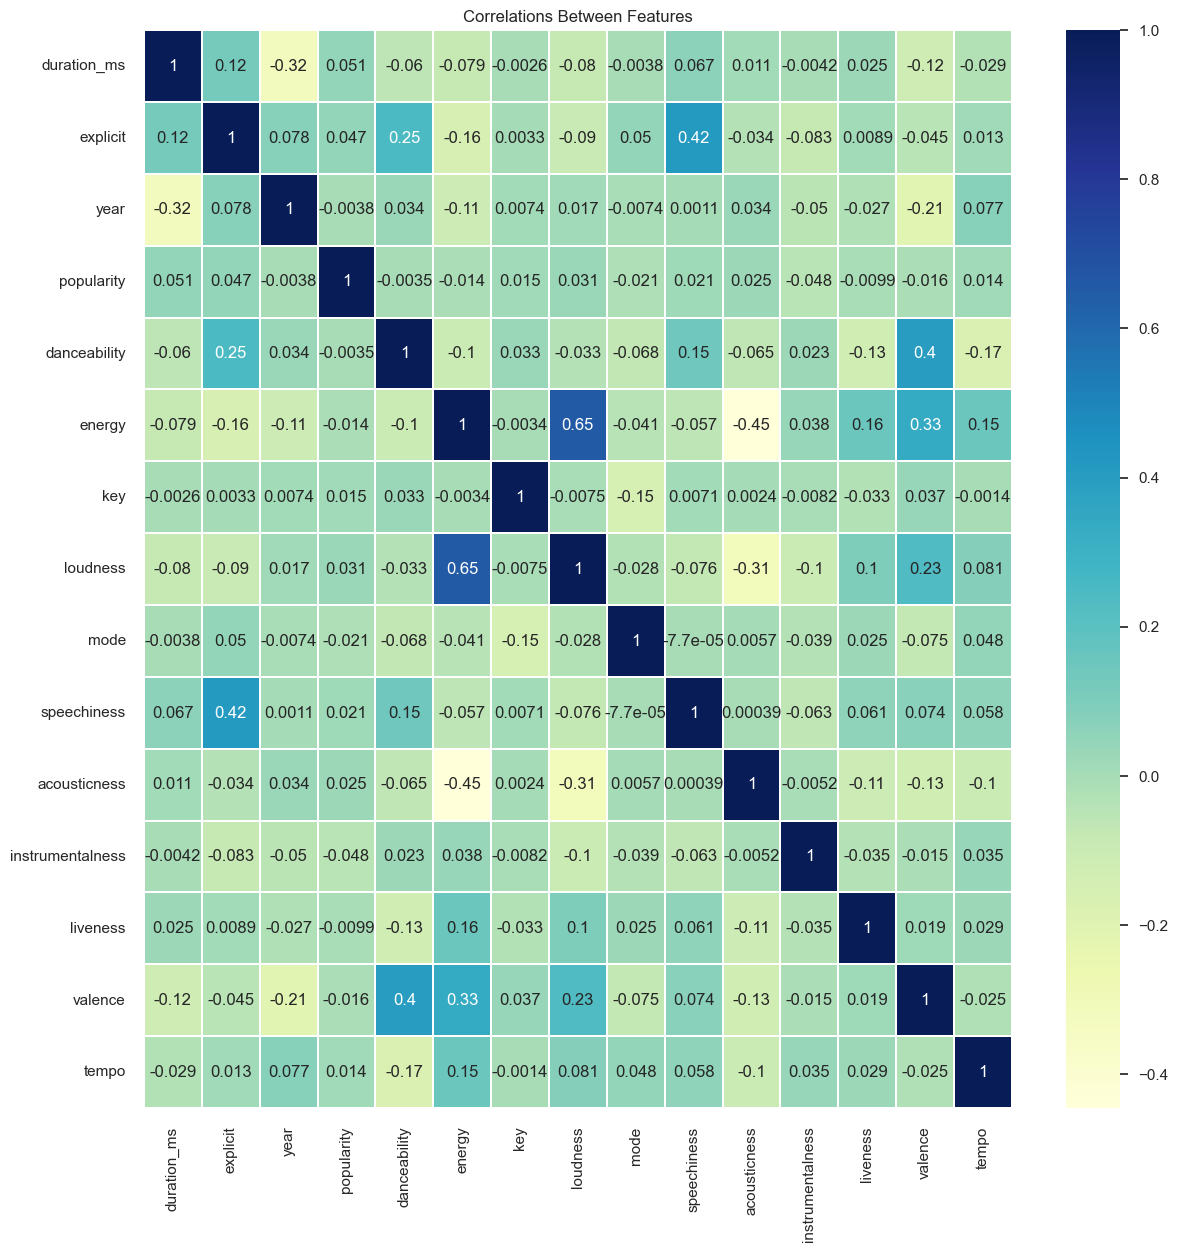

In [9]:
plt.figure(figsize=(14,14))
sns.heatmap(df_cont.corr(), linewidths=0.1, cmap='YlGnBu', annot=True)
plt.title(label='Correlations Between Features')
plt.yticks(rotation=0)

There is a *moderate* correlation (0.65) between **energy** and **loudness**.

## Number of Songs 

<AxesSubplot: title={'center': 'Number of Songs Throughout Time'}, xlabel='decade', ylabel='count'>

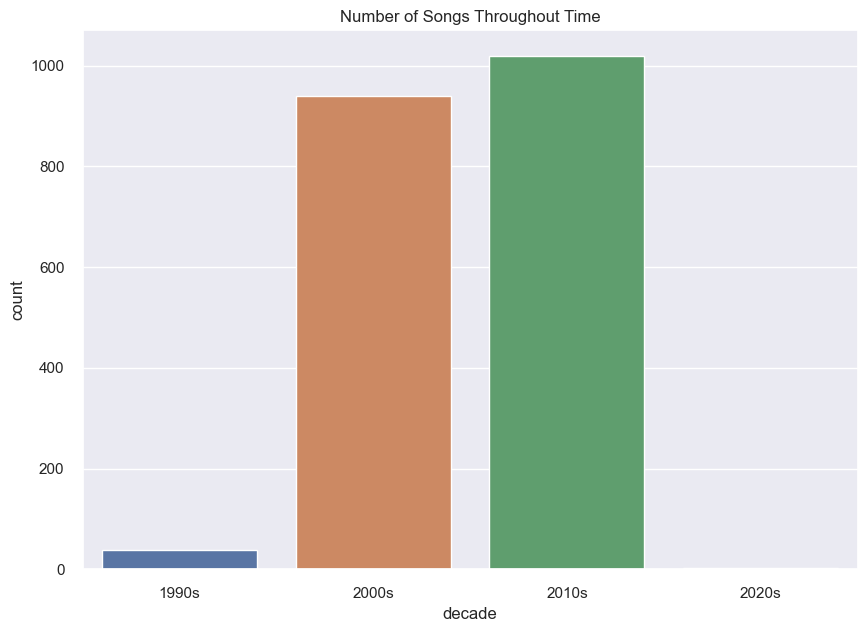

In [10]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

df_cont['decade'] = df_cont['year'].apply(get_decade)
df_sort= df_cont.sort_values('decade')

plt.title('Number of Songs Throughout Time')

sns.set(rc={'figure.figsize':(10 ,5)})
sns.countplot(data= df_sort, x='decade')

We can see that number of top-charting songs increase dramatically as we move from 1990s to 2000s. We then have a slight increase in number of songs in 2010s. We also see that there were very few songs in 2020s. Let's explore that a bit.

In [11]:
years= df_cont['year'].unique().tolist()
years.sort()

print(years)

[1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [12]:
df_2020= df_cont[df_cont['year']== 2020]
len(df_2020)

3

We only have three song in 2020s. That explains why we weren't able to see any significant observation earlier. Let's see how each audio features changed throughout the time.

## Audio Features Throughout the Time

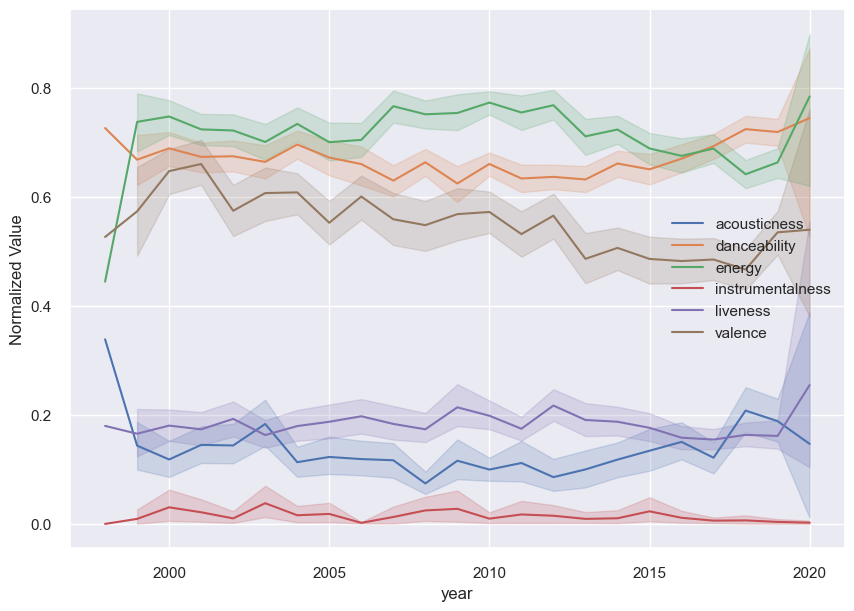

In [13]:
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']

plt.figure(figsize=(10,7))

for i in audio_features:
    sns.lineplot(data=df_cont, x='year', y=i, label= str(i))

plt.ylabel('Normalized Value')
plt.legend()

Songs had **acousticness** around 0.3-0.4, which showed a linear drop to 0.1-0.2. The acousticness stayed in that range throughout, with slight increase during 2015- 2020 region. **Valence** experienced overall declinefrom 0.6-0.7 range to 0.4-0.6 range. **danceability** values stayed constant 2000- 2015. It then started rising from 0.6 range to upward 0.7 range. **Energy** remains consistent throughout 1920s-1950s, staying around 0.7. While it experienced decline between 2010-2017, it quickly rose back to upward of 0.7. **Instrumentalness** stayed consistend throughout, hovering around 0.0- 0.1 range.

## Visualizing Clusters

Since we are working with high-volume, high-dimensional data, it would be useful to perform dimensional reduction, cluster and visualize our data. We will use k-means clustering to cluster our data and PCA to visualize our clusters.

### K-Means Clustering

In [14]:
KMeans_pipe= Pipeline([('scaler', StandardScaler()), ('KMeans', KMeans())])
X= df_cont.select_dtypes(np.number)
num_cols= X.columns.to_list()

KMeans_pipe.fit(X)
cluster_labels= KMeans_pipe.predict(X)
df_cont['cluster_labels']= cluster_labels

### Visualizing Clusters via PCA

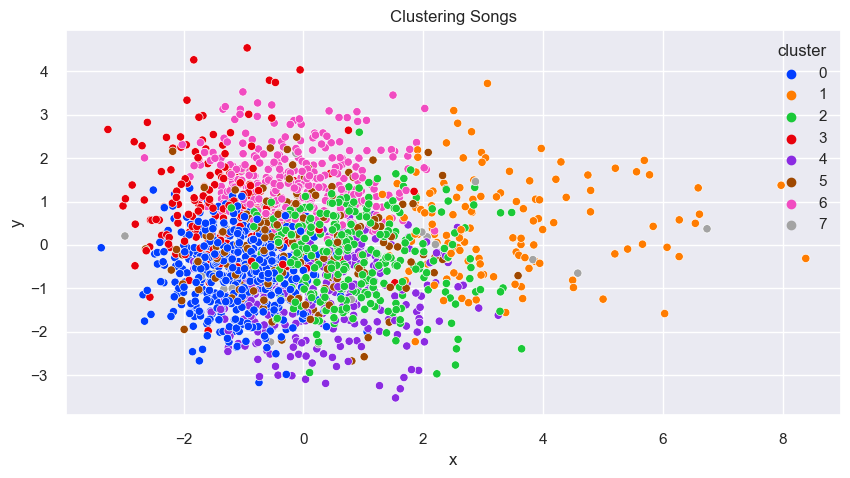

In [15]:
pca_pipeline= Pipeline([('scaler', StandardScaler()),('PCA', PCA(n_components=2))])
transformed_data= pca_pipeline.fit_transform(X)

projection= pd.DataFrame(columns= ['x','y'], data= transformed_data)
projection['title']= df_cont['song']
projection['cluster']= df_cont['cluster_labels']


sns.scatterplot(data= projection, x= 'x', y= 'y', hue='cluster', palette='bright')
plt.title('Clustering Songs')

plt.show()

In [16]:
projection.cluster.nunique()

8

## Collaborative Filtering

In [17]:
df_collab.shape

(12856838, 4)

In [18]:
df_collab.head()

user_id                        artistname  \
0  9cc0cfd4d7d7885102480dd99e7a90d6                    Elvis Costello   
1  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
2  9cc0cfd4d7d7885102480dd99e7a90d6                      Tiffany Page   
3  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
4  9cc0cfd4d7d7885102480dd99e7a90d6                    Elvis Costello   

                                           trackname    playlistname  
0               (The Angels Wanna Wear My) Red Shoes  HARD ROCK 2010  
1  (What's So Funny 'Bout) Peace, Love And Unders...  HARD ROCK 2010  
2                                   7 Years Too Late  HARD ROCK 2010  
3                              Accidents Will Happen  HARD ROCK 2010  
4                                             Alison  HARD ROCK 2010

In [19]:
df_collab.describe()

user_id artistname trackname playlistname
count                           12856838   12856838  12856838     12856838
unique                             15914     289603   2004523       157320
top     4398de6902abde3351347b048fcdc287  Daft Punk     Intro      Starred
freq                              295274      36086      6675      1334319

Let's visualize the data to better understand the data.

Text(0.5, 1.0, 'Number of Unique Listeners and Music')

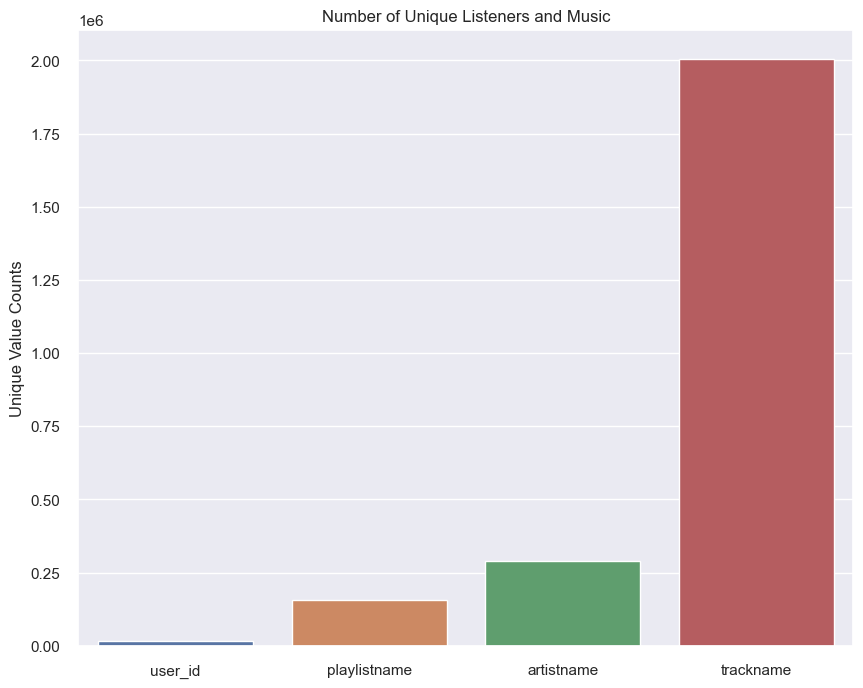

In [20]:
plt.figure(figsize=(10,8))

sns.barplot(x= [x for x in df_collab.columns], y= [df_collab[x].nunique() for x in df_collab.columns], order=['user_id', 'playlistname', 'artistname', 'trackname'] )
plt.ylabel('Unique Value Counts')
plt.title('Number of Unique Listeners and Music')

Although overall counts are the same, we can see that there are more unique tracks and artist names than listeners and playlists. This makes sense, given that listeners tend to add more than one songs to each of their playlists. We can also see that there are more playlists than listeners. This may be from listeners with more than one playlists. Finally, there are more tracks than artists. This may be because listeners may save more than one track by a given artist (hence favorite artist(s))! 